# Lab 7: Painting and Drawing - the ART of Simulated Annealing

This week in class, we saw that Simulated Annealing is a useful implementation of a Metropolis-style algorithm for numerically finding optimal values to a particular problem in a relative short time. Today, we are going to explore how we go about setting-up a Simulated Annealing, when it is useful to invoke SA, and in particular how we set the initial conditions that control the 'climate' of the optimization system....the ART of Simulated Annealing. 

## 1. Ruining a perfectly good past time!

We are going to begin today with a multi-dimensional system that would otherwise be difficult to solve, both numerically, or systematically by hand...a SUDOKU puzzle.

For those who haven't seen these before, a sudoku puzzle typically consists of a square grid of 3x3 blocks each containing 3x3 cells. This has of course be scaled up to n>3 for really sadistic gamers, but we're going to stick with the well-known 3x3 situtation. The puzzle begins with  a variable number of  integers in specified (fixed) positions on the game board. The objective is to fill in the remaining cells so that each row, column and block contains only distinct and unique integers from 1 to 9. Easy! (...or not). Depending on the start position, these can sometimes be solved systematically by selecting individual empty cells that can only have one possible outcome based on the misisng integers from the associated row, column and block.

Here is an example where a systematic approach will not work:

In [75]:
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_sudoku(n):
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    plt.figure()
    for y in range(10):
        plt.plot([-0.05,9.05],[y,y],color='black',linewidth=1)
        
    for y in range(0,10,3):
        plt.plot([-0.05,9.05],[y,y],color='black',linewidth=3)
            
    for x in range(10):
        plt.plot([x,x],[-0.05,9.05],color='black',linewidth=1)
    
    for x in range(0,10,3):
        plt.plot([x,x],[-0.05,9.05],color='black',linewidth=3)

    plt.axis('image')
    plt.axis('off') # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            foo=n[8-y][x] # need to reverse the y-direction for plotting
            if foo > 0: # ignore the zeros
                T=str(foo)
                plt.text(x+0.3,y+0.2,T,fontsize=20)

    plt.show()

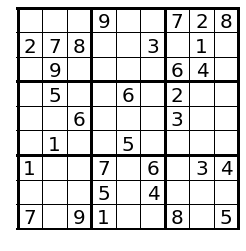

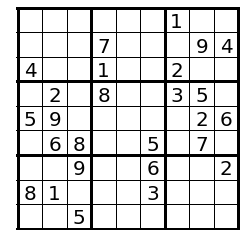

In [76]:
sudoku_hard=np.array([[0,0,0,9,0,0,7,2,8],
                      [2,7,8,0,0,3,0,1,0],
                      [0,9,0,0,0,0,6,4,0],
                      [0,5,0,0,6,0,2,0,0],
                      [0,0,6,0,0,0,3,0,0],
                      [0,1,0,0,5,0,0,0,0],
                      [1,0,0,7,0,6,0,3,4],
                      [0,0,0,5,0,4,0,0,0],
                      [7,0,9,1,0,0,8,0,5]])
plot_sudoku(sudoku_hard)

sudoku_easy=np.array([[0,0,0,0,0,0,1,0,0],
                      [0,0,0,7,0,0,0,9,4],
                      [4,0,0,1,0,0,2,0,0],
                      [0,2,0,8,0,0,3,5,0],
                      [5,9,0,0,0,0,0,2,6],
                      [0,6,8,0,0,5,0,7,0],
                      [0,0,9,0,0,6,0,0,2],
                      [8,1,0,0,0,3,0,0,0],
                      [0,0,5,0,0,0,0,0,0]])
plot_sudoku(sudoku_easy)

Ok, so we have a puzzle that we can't solve through simple logic. How are we going to solve it?...USING RANDOM NUMBERS OF COURSE!

Indeed, the simplest approach would be to: <br>
1) take the set of integers A = {1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2...8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9}<br>
2) remove all of the numbers from the set that already exist in our sudoku example, B <br>
3) randomly include the remainder intergers (A not in B) in our grid, and determine if the solution criteria is satisfied. <br>

### Why is this a terrible idea!?

<b>Answer:</b> let's just do a simple order of magnitude, back of the envelope style calculation.<br>

There are $9 \times 9 =81$ squares in our grid. 26 of these are aleady filled. Leaving 65 empty squares. There are 9 possible numbers that can go into each of the 65 squares, so there are $\sim 10^{60}$ combinations. <br> Let's make a conservative assumption that we can randomly select from our subset, include these into the grid, and then do a test to see if we have solved the puzzle in 1 nano-second (using 1 core), and just because we can, let's say we have a 12-core Mac Pro, so we can do 12 selections at once if we fork our code properly.

So, brute force style it will take $10^{50}$ seconds to go through all the possible combinations. Let's also say, we get lucky and we only go through 1% of the combinations before we find the result. So, exactly how long is $10^{48}$ seconds? Well, the age of the Universe is roughly $4 \times 10^{17}$ seconds...see, a terrible idea!


### How do we invoke SA to solve this?

We've alredy said that random numbers are the solution here, we just need to be smarter in the way that we do our trials. We know that we achieve this in SA, by comparing the system energy of our previous guess, and comparing this to the energy of our new proposal. So what is the 'energy' in terms of a sudoku puzzle?<br>

Clearly, there is an absolute solution here, so we would expect that $E=0$ for the solution. And $E>0$ for any other incorrect 'solution'. But what makes one solution more wrong than another (i.e., $E>>0$)? <br> 

Let's consider what a correct solution would look like. It would have only unique integers in each row, column and 3x3 box. So, if in a particular row, we had the same number twice, then this must be wrong, and this row would not have $E=0$, but $E=1$, i.e., there is 1 incorrect number. So, the energy of our system is simply the sum of all non-unique numbers in each column, row and 3x3 box. Conversely, we can think of this as the number of unique elements in each row, column, and box, and then we get back to $E=0$ by susbtracting what the enrgy of a correct solution would be, $9 \times 9 \times 3 = 243$, <br>
<center>$ E_{\rm tot} = 243 - \sum_{i,j,k} E_{\rm row,i} + E_{\rm col,j} + E_{box,k}$</center>

In [70]:
def check(i,k,n):
    #determines number of unique elements in each row (k=1) or column (k!=1)
    nums=np.arange(9)+1
    nu=0
    for j in range(9):
        if k==1:
            i1 = n[i][j]-1
        else:
            i1 = n[j][i]-1

        if i1==-1: # Quick check that there are no zeros
            return -1
        
        if nums[i1]!=0:
            nu+=1
            nums[i1]=0
  
    return nu

def checksq(isq, jsq, n):
    # determines number of unique elements in square isq, jsq
    nums=np.arange(9)+1
    nu = 0
    i0 = isq*3
    j0 = jsq*3
    for i in range(3):
        for j in range(3):
            i1 = n[i0+i][j0+j] - 1

            if i1==-1: # Quick check that there are no zeros
                return -1
        
            if nums[i1]!=0:
                nu+=1
                nums[i1]=0
                
    return nu

def calc_energy(n):
    # computes the "energy" of the input grid configuration
    sum = 0
    for i in range(9):
        sum += check(i,1,n) + check(i,2,n)
    
    for i in range(3):
        for j in range(3):
            sum += checksq(i,j,n)

    return 243 - sum

It's important to remember which are the fixed numbers specific to this puzzle, these cannot be moved between interations. We can just use a mask for this.

In [71]:
n = sudoku_hard
mask = n>0

Now, we need a starting position. For this we can take the missing integers from our sudoku example, and apply them pseudo-randomly to the grid. Why pseudo-randomly? We know enough about the final configuration that we can be clever in the way that we distribute the remaining values. We know that the values {1,2,3,4,5,6,7,8,9} must appear in each 3x3 box, so we should only populate those 3x3 squares with those numbers minus those which already exist from this set. 

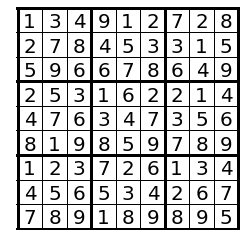

In [72]:
# Assign the remaining integers to open cells so that each block contains all integers once only.
for ib in range(3):
    for jb in range(3):

        nums=np.arange(9)+1  #{1,2...8,9}
        for i in range(3):
            for j in range(3):	 
                i1 = ib*3 + i
                j1 = jb*3 + j

                if n[i1][j1]!=0:
                    ix = n[i1][j1]
                    # replace the already used number with 0
                    nums[ix-1]=0

        # Now we have an array that contains the unused numbers.
        # So we populate using that array.
        iy = -1
        num1=np.zeros(sum(nums>0))
        for k in range(9):
            if nums[k]!=0:
                iy+=1
                num1[iy] = nums[k]

        kk = 0
        for i in range(3):
            for j in range(3):
                i1 = ib*3 + i
                j1 = jb*3 + j
                if(n[i1][j1]==0):
                    n[i1][j1] = num1[kk]
                    kk+=1
                 
plot_sudoku(n)

In [73]:
# What is the energy of our starting position?
e_prev = calc_energy(n)
print 'The system Energy of the initial configuration is:', e_prev

The system Energy of the initial configuration is: 48


Now, we just do the SA. Let's first pull some artsy numbers out of thin air, and we'll discuss these in greater detail later.

In [74]:
temp = 2.0 # starting temperature
ntrial = 100000 # number of trials we are going to run
thermo= 0.9 # thermostat for the temperature when it's too hot
reanneal=1000 # how often do we apply the thermostat?

How should we decide how to construct a proposal? If we are going to smart about this and use SA, then the proposal shouldn't just come out of thin air, it should be based loosely on the accepted grid from the previous iteration. So, we trade numbers. We take a 'movable' number at one grid space and swap it with the number at another grid space. But remember, we distributed the numbers so that in each 3x3 box we had the numbers 1-9. To maintain this, we should make sure that we only swap numbers within the same 3x3 box. We then compute the energy of our proposal grid. If the energy goes down, then we accept. Otherwise toss a coin according to,

<center>${\rm randU}(1) < {\rm exp}\left[-\Delta E / T\right] $</center>

0 1.74290899863 47 47
5000 6.56450052363 20 20
10000 0.00170656774763 20 24
15000 0.00453198485618 9 11
20000 1.15294295668e-08 2 6
FOUND IT :-D
Solution found after 20456 steps


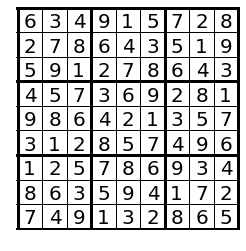

In [23]:
for ll in range(ntrial):

    # at each step pick at random a block and two moveable elements in the block
    ib,jb = 3*np.random.randint(3,size=2)

    i1,j1 = np.random.randint(3,size=2)
    while mask[ib+i1][jb+j1]:
        i1,j1 = np.random.randint(3,size=2)

    i2,j2 = np.random.randint(3,size=2)
    while mask[ib+i2][jb+j2] or (i1==i2 and j1==j2):
        i2,j2 = np.random.randint(3,size=2)

    # swap the movable elements and compute the energy of the trial configuration
    propose_n=n.copy()
    propose_n[ib+i1][jb+j1] = n[ib+i2][jb+j2]
    propose_n[ib+i2][jb+j2] = n[ib+i1][jb+j1]

    # calculate the proposal system energy
    e_new = calc_energy(propose_n)
    deltaE = e_prev - e_new

    # Check the SA criterion
    if e_new < e_prev:
        e_prev = e_new
        n = propose_n
    else:
        if np.random.rand() < np.exp( float(deltaE)/temp):
            e_prev = e_new
            n = propose_n

    # stop computing if the solution is found
    if e_prev==0:
        print "FOUND IT :-D"
        break

    if(ll % reanneal) == 0:
        temp=temp*thermo
        if temp<0.1:
            temp=0.5
            
    # is the code still running properly...?
    if(ll % 5000) == 0:
        print ll,np.exp( float(deltaE)/temp),e_prev,e_new

if e_prev==0:
    print "Solution found after", ll, "steps"
    plot_sudoku(n)

So, how do we improve on this? Can we speed this up? <br>

There are three ways to approach this:<br>
(1) why limit ourselves to only one swap per iteration, at least at the beginning?<br>
(2) intial temperature<br>
(3) thermostat tuning<br>

## 2) Going on a trip - (re-)visiting the traveling salesman

Temperature tuning in the Sudoku puzzle can be a real problem. Yes, you can get very close to the solution in terms of system energy, but it could be a long way from the real solution. A simple bad swap and everything could break down. So, to better understand how to 'paint' before we start 'drawing', let's take another trip with the Traveling Salesman.<br>

As we saw in class, this is an extremely well-studied problem, and does not need to be limited to only one mode of transport, or visiting each city once. Specific applications can become hair-raising very quickly. But it is still an interesting situation to consider how parameter tuning works.<br>

Let's produce some starting grid, which will represent our cities.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


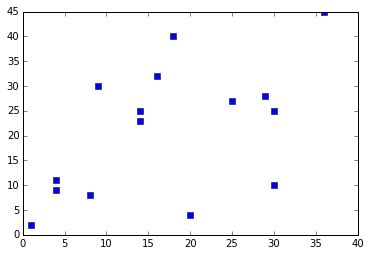

In [25]:
cities=np.random.randint(0,50,(2,15))
plt.plot(cities[0,:], cities[1,:], 'bs')

In [26]:
# Here we going to use the same code that was seen in class

def get_norm(a,b):
    sub = a - b
    return np.sqrt(np.sum(sub*sub))

def distance(pathcities):
    d=0.
    total=pathcities.shape[1]
    for j in range(total):
        if j==total - 1: # FINAL POINT CONNECTS WITH THE FIRST ONE
            d = d +  get_norm( pathcities[:,j], pathcities[:, 0])
        else:
            d = d +  get_norm( pathcities[:,j], pathcities[:, j+1])
    return d

def changepath(inputcities, L):
    indexes = range(inputcities.shape[1])
    q=inputcities.copy()
    for i in range(L):
        a=swapindex(q)
        q=a.copy()

    return q

def swapindex(p):
    indexes = range(p.shape[1])
    c1 = np.random.choice(indexes)
    c2 = np.random.choice(indexes)
    foo1 = p[:,c2]
    foo2 = p[:,c1]
    b=p.copy()
    b[:, c1] = foo1
    b[:, c2] = foo2
    return b

In [27]:
def sa( pathcities, init_temp, thermostat, ftol, itol, otol, reannealing):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================

    m=100     
    distsize=otol+1
    dist=[]
    temperature = init_temp   


    N = pathcities.shape[1]
    it = 0                    

    # DISTANCE HERE IS OUR ENERGY 
    prev_E = distance(pathcities)  
    #print "prevE st start", prev_E
    atp=0
    while it >=0:
        # NUMBER OF CORNERS IS L
        L = np.floor(np.sqrt(temperature)).astype(int)
        #print "L", L
        propose_path = changepath(pathcities, L)

        new_E = distance(propose_path)
        #print "newe", new_E
        deltaE  =  new_E -prev_E 

        if new_E < prev_E:
            pathcities  = propose_path
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E  
            it = it+1
        elif np.random.rand() < np.exp( -deltaE/temperature):
            pathcities  = propose_path
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E 
            it = it+1

        atp =atp +1;  # NUMBER OF ITERATIONS
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            #temperature =  temperature/log(it);
            compl_temp=0;
            if temperature < 1:
                temperature = 4
        
        #if it<5: fig=plt.plot( distances, 'r.')
        #if it<5: display.clear_output()
        #if it<5: display.display(plt.gcf())
    
        #print dist
        if len(dist)>m and np.std(dist[-m:])/np.mean(dist[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(dist)> 0 and dist[-1] <= otol:
            print 'otol'
            print dist[-1]
            break

    s = pathcities
    return s, dist


ftol


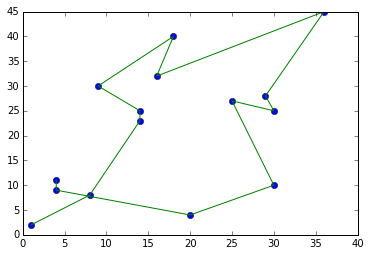

In [28]:
pcities, distances = sa(cities, 10, 0.9, 0.1, 10000, 0,10)
plt.plot(pcities[0,:], pcities[1,:],'o')
plt.plot(pcities[0,:], pcities[1,:])

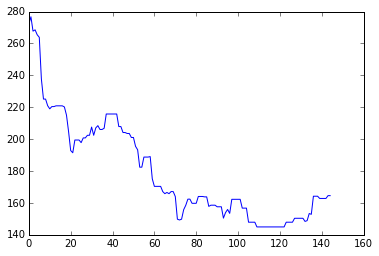

In [29]:
plt.plot(distances)

So, why did we choose those initial values for the temperature and the re-heating?<br>

What can we take away from this distances plot? What is it that we were physically trying to achieve at each iteration?

# 3. Astrometric Calibration and Alignment

For this example we are going to take a look at a more practical application of simulated annealing, we are going to attempt to align a set of (simulated) images taken of the sky by NASA's Chandra X-ray Observatory.<br>

First a bit of background: at some point you have undoubtedly seen a beautiful optical image of a nearby spiral galaxy, showing intense regions of star-formation, a galactic bulge, structured arms etc. etc. Unfortunately, X-ray astronomy is not quite as glamorous. Unlike optical photons, which are more than abundent in the night sky, X-ray photons are few and far between. What's more they have extremely high energies. High energy means they are difficult to focus and they are difficult to capture [a quick analogy: try catching a bullet in a plastic bucket when it was fired from a gun just 50 feet away - see, difficult!]. The result of this, is that instead of an optical image of a nearby galaxy, which is made of millions of pixels containing 10,000s photon counts/pixel, an X-ray image of the same galaxy, or even a group of more distant galaxies may only contain 10s or 100s of X-ray photons.<br>

Here is an example of a typical false-color X-ray image of very nearby spiral galaxy. Not quite the pictures that we're used to in the press. The center of the image is zoomed in for clarity. And a few background objects are highlighted with green circles. These are about to become very important.

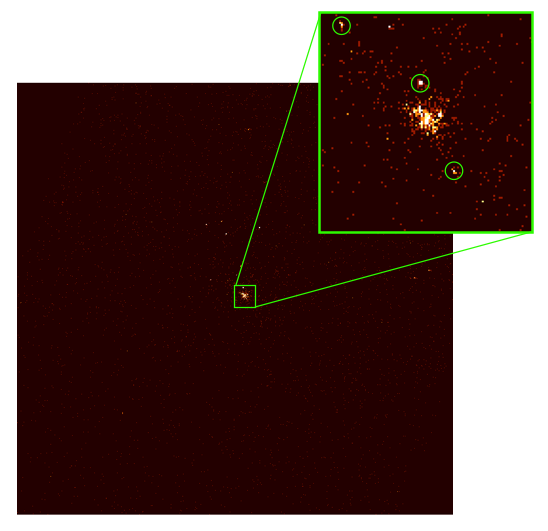

In [80]:
from IPython.core.display import Image
Image('./cxo1.png')

Imagine now that we point the Chandra Telescope at a reigon of the sky that doesn't contain a nice big nearby galaxy, but for all intents and purposes it is 'blank'. Basically, this a reigon of the sky where if you were to look long and hard enough you would just detect a few X-ray from a a handful of very distant galaxies. In fact, they would look just like those point sources that are highlighted with the green circles in the above image.<br>

But X-ray telescopes are not very large, and they are very expensive, as such they only have small fields of view, i.e., the small area of the sky that they can see at any one time. So, if you want to have a single X-ray image of a particular region of the sky, which is larger than the field of view of the telescope, you have to tile. Basically, you take several snapshots of the region of the sky you are interested in, and you just move the telescope over a little, and maybe it gets rotated too (it is in orbit afterall).<br>

Then to build the single image you have to align each of the individual images so that are all mapped to the same sky co-ordinate system. Simples!

### How do we know if each of the individual observations are all aligned to the same co-ordinates?

<b> Answer:</b> by checking to see if the background sources are all in the same place in the sky co-ordinates.<br>

Here is a really simple example. These are two photographs of a flower taken with the same camera, but one of the photographs was pointing at a slightly different region of the flower, and the camera was rotated. Then directly below, we have the resultant image when the images have been aligned to the same 'sky' co-ordinates: 

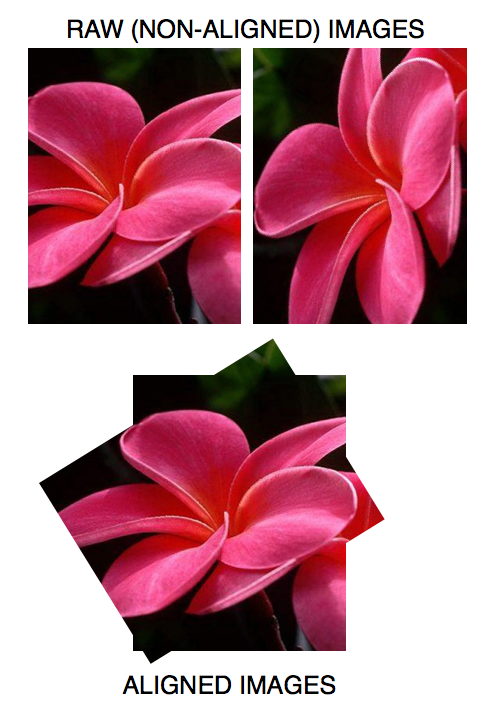

In [81]:
from IPython.core.display import Image
Image('./flower.png')

The situation is that we have been a taken 5 Chandra images of a particular region of the sky that is slightly wider and taller than the standard Chandra field of view. And now we need to use the objects that are seen in each of these images to try and align them to the same co-ordinates. Unlike the picture of the flower, it is not going to be easy. All we have to play with are the 10-30 dots seen in each of the individual images, and we have no way of knowing which is which. Or do we...? Here are the five X-ray 'images'.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

obs0=np.loadtxt("./obs_0_0_0deg.tbl")
obs1=np.loadtxt("./obs_5_10_10deg.tbl")
obs2=np.loadtxt("./obs_8_-7_340deg.tbl")
obs3=np.loadtxt("./obs_-10_7_345deg.tbl")
obs4=np.loadtxt("./obs_-6_-6_20deg.tbl")

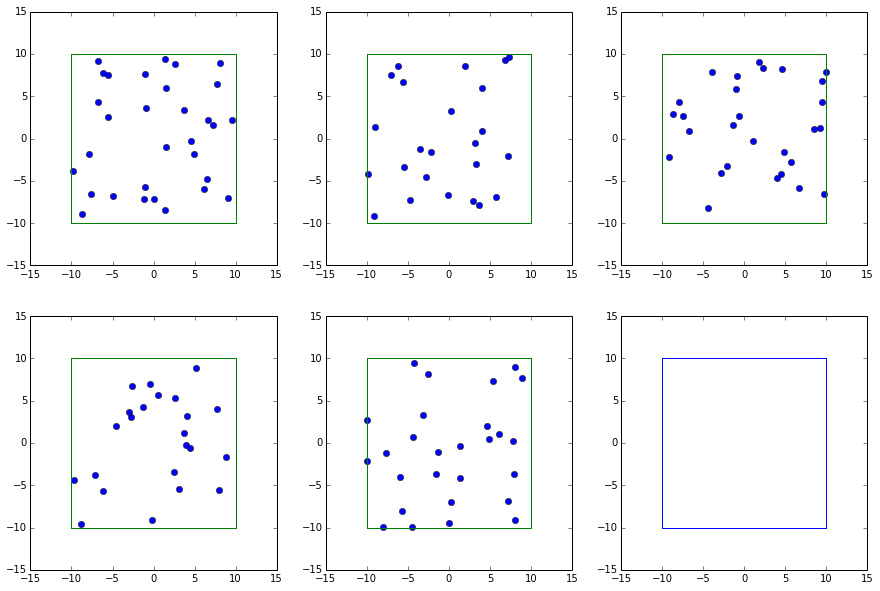

In [2]:
fig, axes=plt.subplots(figsize=(15,10), nrows=2, ncols=3)
axes[0][0].plot(obs0[:,0], obs0[:,1],'o')
axes[0][1].plot(obs1[:,0], obs1[:,1],'o')
axes[0][2].plot(obs2[:,0], obs2[:,1],'o')
axes[1][0].plot(obs3[:,0], obs3[:,1],'o')
axes[1][1].plot(obs4[:,0], obs4[:,1],'o')

for i in range(3):
    for j in range(2):
        axes[j][i].set_ylim([-15,15])
        axes[j][i].set_xlim([-15,15])
        axes[j][i].plot([-10,10,10,-10,-10], [10,10,-10,-10,10])

Let's begin by taking one of these images as a reference frame, which all of the other images will then be mapped to. The co-ordinate system of image one is going to act as our sky co-ordinates for this demonstration, where the origin of the sky is the origin of obs0.

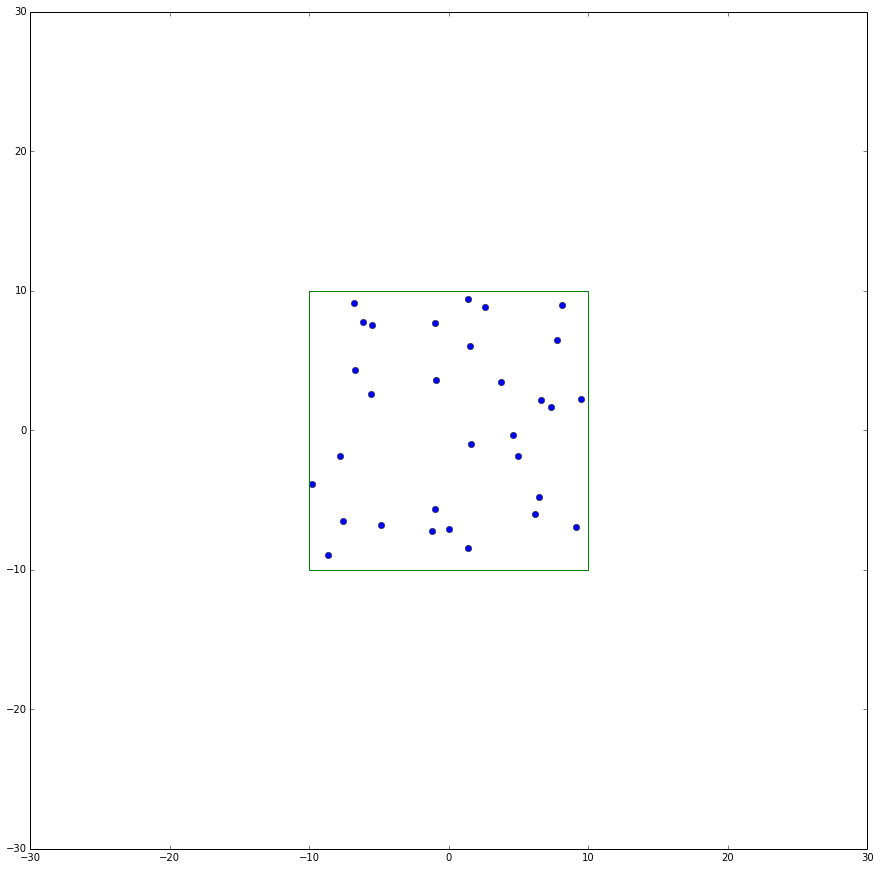

In [67]:
cxo_fov=np.array([[-10.,10.,10.,-10.,-10.],[10.,10.,-10.,-10.,10.]])

fig=plt.figure(figsize=(15,15))
plt.plot(obs0[:,0], obs0[:,1],'o')
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.plot(cxo_fov[0,:], cxo_fov[1,:])
plt.show()

In [69]:
def rotate_cxo(deltax,deltay,rot):
    # Routine to rotate and translate the FOV of a Chandra image using a simple geometric conversion. 
    radeg=180./np.pi
    cxo_fov=np.array([[-10.,10.,10.,-10.,-10.],[10.,10.,-10.,-10.,10.]])

    xdash = (cxo_fov[0,:]*np.cos(rot/radeg) + cxo_fov[1,:]*np.sin(rot/radeg))+deltax
    ydash = (cxo_fov[1,:]*np.cos(rot/radeg) - cxo_fov[0,:]*np.sin(rot/radeg))+deltay
    
    xydash=np.zeros([2,5]) # initialize output
    xydash[0,:]=xdash 
    xydash[1,:]=ydash 

    return xydash

def rotate_sources(inplist,deltax,deltay,rot):
    # Routine to translate source list
    radeg=180./np.pi
    xdash = (inplist[:,0]*np.cos(rot/radeg) + inplist[:,1]*np.sin(rot/radeg))+deltax
    ydash = (inplist[:,1]*np.cos(rot/radeg) - inplist[:,0]*np.sin(rot/radeg))+deltay
    
    outlist=np.zeros([xdash.shape[0],2])
    outlist[:,0]=xdash
    outlist[:,1]=ydash
    return outlist

## Implementing SA in this problem

Now that we have all of our images with the detected source positions, and we have defined some reference co-ordinate grid we need to implement SA to align the images. How do we go about this?<br>

<ul>
<li> Take a random starting position for the image you would like to align to the reference co-ordinates, let's call this IMG$_{\rm align}$. This involves randomly choosing a set of translation co-ordinates and a rotation, $x',y',\theta$. We can choose these using a uniform random generator.
<li> Apply $x',y',\theta$ to the sources detected in IMG$_{\rm align}$.
<li> Identify which of the translated sources (in IMG$_{\rm align}$) lie within the overlapping of IMG$_{\rm ref}$ and IMG$_{\rm align}$, and calculate the total distance, $d$, between the translated sources in IMG$_{\rm align}$ and the most nearby counterpart source in IMG$_{\rm ref}$. This will be the starting energy, $E_{\rm prev}$, of our system.
<li> Make a new proposal step, i.e., a new set of {$x',y',\theta$}$_{\rm prop}$
<li> Calculate $E_{\rm prop}$ and use the SA criterion
<li> Repeat until we hit an alignment threshold
</ul> 

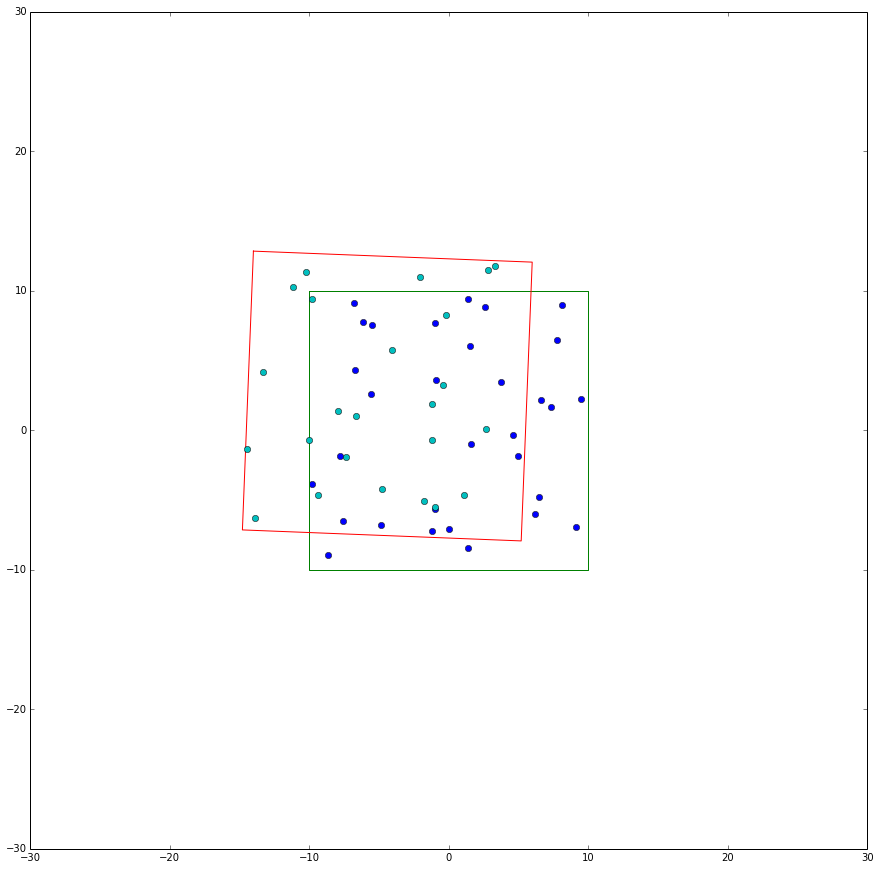

In [70]:
# Let's begin with our starting position
rot=2.25931272 # set the rotation of img_align
deltax=-4.42021348
deltay=2.45717335

cxo_prev=rotate_cxo(deltax,deltay,rot)
trans_sce=rotate_sources(obs1,deltax,deltay,rot)

fig=plt.figure(figsize=(15,15))
plt.plot(obs0[:,0], obs0[:,1],'o')
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.plot(cxo_fov[0,:], cxo_fov[1,:])
plt.plot(cxo_prev[0,:],cxo_prev[1,:])
plt.plot(trans_sce[:,0], trans_sce[:,1],'o')
plt.show()

In [127]:
def calc_intersect_coords(cxo_fov,cxo_prop):
    # A function that accepts the co-ordinates for the corners of two chandra FOVs
    # It calculates the determinent between each of the corner sets to find if any intercept with each other
    # It then calculates if any of the corners are within the bounds of the other FOV.
    # Sorts the new intersecting co-ordinate list according to a clockwise direction
    # Outputs the intersecting co-ordinate list

    overlap_x=np.array([])
    overlap_y=np.array([])
    for i in range(4):
        x1=cxo_fov[0,i]
        y1=cxo_fov[1,i]
        x2=cxo_fov[0,i+1]
        y2=cxo_fov[1,i+1]

        for j in range(4):
            x3=cxo_prop[0,j]
            y3=cxo_prop[1,j]
            x4=cxo_prop[0,j+1]
            y4=cxo_prop[1,j+1]

            px= ((x1*y2 - y1*x2)*(x3 - x4) - (x1-x2)*(x3*y4 - y3*x4)) / ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
            py= ((x1*y2 - y1*x2)*(y3 - y4) - (y1-y2)*(x3*y4 - y3*x4)) / ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
            if (-10.01<=px<=10.01 and -10.01<=py<=10.01 
                and (np.min(cxo_prop[0,:])-0.01)<=px<=(np.max(cxo_prop[0,:])+0.01) 
                and (np.min(cxo_prop[1,:])-0.01)<=py<=(np.max(cxo_prop[1,:])+0.01)):
                overlap_x = np.append(overlap_x,px)
                overlap_y = np.append(overlap_y,py)
                

        if (min(cxo_prop[0,:])<=x1<=max(cxo_prop[0,:]) and min(cxo_prop[1,:])<=y1<=max(cxo_prop[1,:])):
            overlap_x = np.append(overlap_x,x1)
            overlap_y = np.append(overlap_y,y1)
            
            
    for j in range(4):
        x3=cxo_prop[0,j]
        y3=cxo_prop[1,j]
        
        if (min(cxo_fov[0,:])<=x3<=max(cxo_fov[0,:]) and min(cxo_fov[1,:])<=y3<=max(cxo_fov[1,:])):
            overlap_x = np.append(overlap_x,x3)
            overlap_y = np.append(overlap_y,y3)
            

    # Now sort the co-ordinates according to a clockwise order. Use polar co-ordinates for this.
    alpha= (180./np.pi) * np.arctan2( overlap_x - np.mean(overlap_x) , overlap_y - np.mean(overlap_y) )
    clock_order= alpha.argsort()
    out_x=overlap_x[clock_order]
    out_y=overlap_y[clock_order]
    
    outlist=np.zeros([2,overlap_x.shape[0]])
    outlist[0,:]=out_x
    outlist[1,:]=out_y
    
    if overlap_x.shape[0] < 3:
        print overlap_x,overlap_y
        print np.min(cxo_prop[0,:])
        print np.max(cxo_prop[0,:])
        print np.min(cxo_prop[1,:])
        print np.max(cxo_prop[1,:])


    return outlist

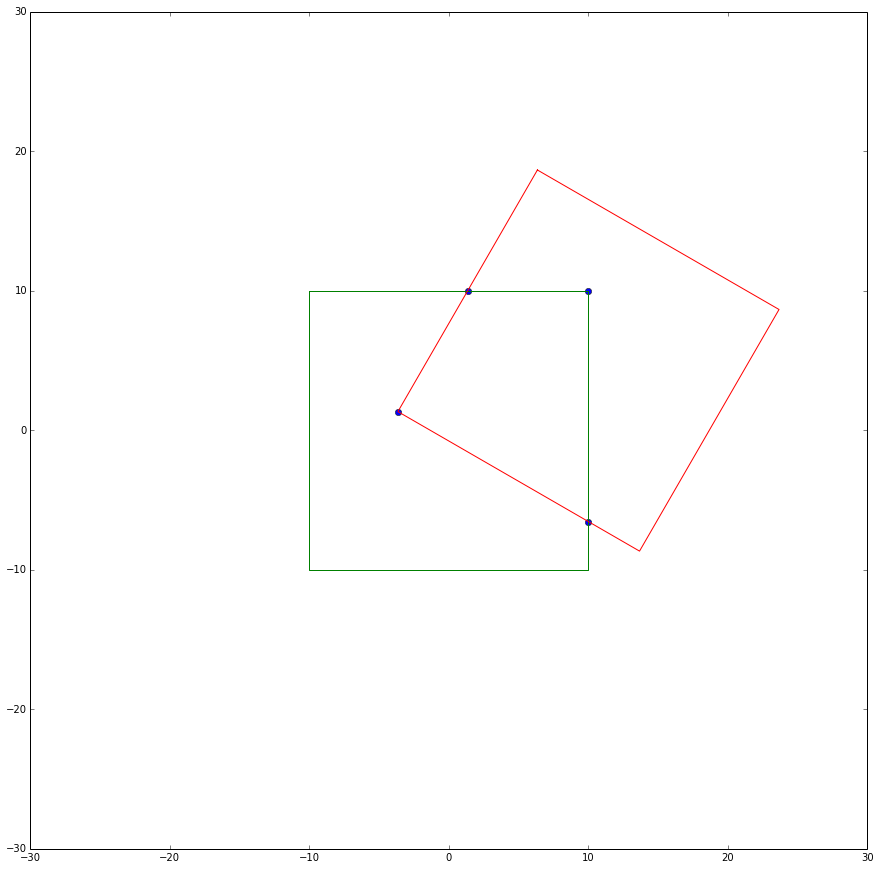

In [128]:
foo=calc_intersect_coords(cxo_fov,cxo_prev)

fig=plt.figure(figsize=(15,15))
plt.plot(foo[0,:], foo[1,:],'o')
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.plot(cxo_fov[0,:], cxo_fov[1,:])
plt.plot(cxo_prev[0,:],cxo_prev[1,:])
plt.show()

Now we need to calulcate which of the sources present in IMG$_{\rm align}$ lie within the region bounded by the blue points in the above image. These will become the test sources to calculate the system energy.

In [100]:
def pointinpolygon(x,y,inputpoly):
    # Calculate if a point is within a polygon by tracing a line eastwards from the point.
    # If it inserects with an odd number of boundaries then it's within the polygon. Even it's outside. 
    poly=np.transpose(inputpoly)
    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

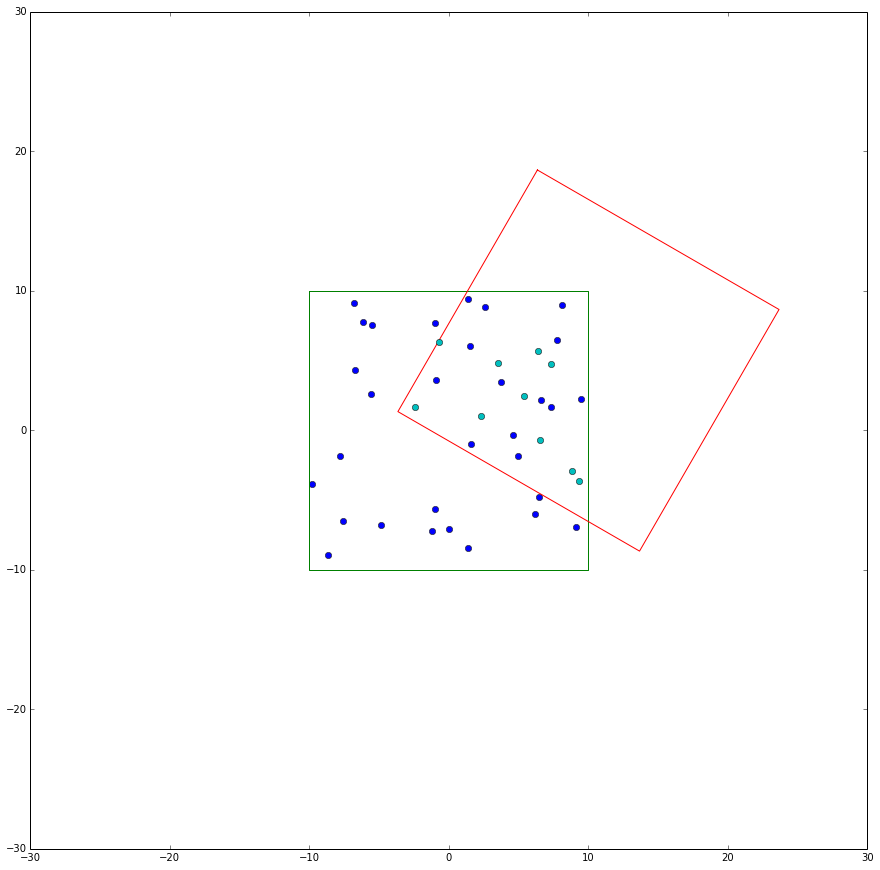

In [101]:
def sourcesinpolygon(sce_list,inp_poly):
    # Calculate which sources are within the polygon
    sce_in=sce_list[:,0]<-99
    for i in range(sce_list.shape[0]):
        x=sce_list[i,0]
        y=sce_list[i,1]
        sce_in[i]=pointinpolygon(x,y,inp_poly)
    return sce_in

mask=sourcesinpolygon(trans_sce,foo) # Mask array for sources inside the polyon bounds

fig=plt.figure(figsize=(15,15))
plt.plot(obs0[:,0], obs0[:,1],'o')
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.plot(cxo_fov[0,:], cxo_fov[1,:])
plt.plot(cxo_prev[0,:],cxo_prev[1,:])
plt.plot(trans_sce[mask,0], trans_sce[mask,1],'o')
plt.show()

Now we need to calculate the distance from each of the cyan dots (from IMG$_{\rm align}$) to their closest neighbors in the IMG$_{\rm ref}$, the blue dots.

In [102]:
def closestsource_totaldist(list1,listref):
    dist=0.
    for i in range(list1.shape[0]):
        r=np.sqrt((listref[:,0]-list1[i,0])**2 + (listref[:,1]-list1[i,1])**2)
        dist += np.min(r)
    return dist

We have all the machinary in place to just do the simulated annealing now.

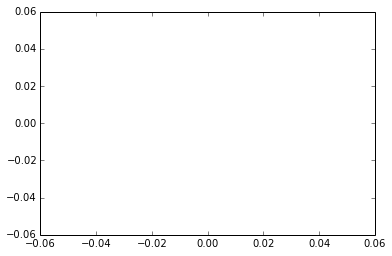

39.3922673668


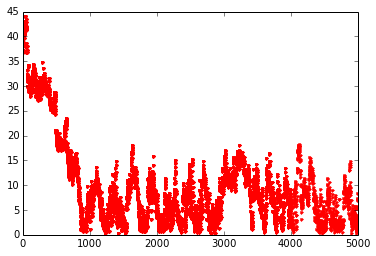

In [159]:
temperature=10.
it=0
atp=0
obs_sce_list=obs1
dist=[]
thermostat=0.9
reannealing=20
plt.plot( dist)
plt.show()

prev_roll=0.
prev_deltax=1.
prev_deltay=1.

cxo_prev=rotate_cxo(prev_deltax,prev_deltay,prev_roll)
trans_sce=rotate_sources(obs1,prev_deltax,prev_deltay,prev_roll)
polybounds=calc_intersect_coords(cxo_fov,cxo_prev)
mask=sourcesinpolygon(trans_sce,polybounds)
prev_E=closestsource_totaldist(trans_sce[mask],obs0)
print prev_E

new_roll=prev_roll+np.random.uniform(low=-1.,high=1.,size=1)
new_deltax=prev_deltax+np.random.uniform(low=-0.25,high=0.25,size=1)
new_deltay=prev_deltay+np.random.uniform(low=-0.25,high=0.25,size=1)

while atp <=10000:
    
    new_roll=prev_roll+np.random.uniform(low=-1.,high=1.,size=1)
    new_deltax=prev_deltax+np.random.uniform(low=-0.25,high=0.25,size=1)
    new_deltay=prev_deltay+np.random.uniform(low=-0.25,high=0.25,size=1)
    while (new_deltax>11. or new_deltax<-11. or new_deltay>11. or new_deltay<-11.):
        new_roll=prev_roll+np.random.uniform(low=-1.,high=1.,size=1)
        new_deltax=prev_deltax+np.random.uniform(low=-0.25,high=0.25,size=1)
        new_deltay=prev_deltay+np.random.uniform(low=-0.25,high=0.25,size=1)
        
    cxo_new=rotate_cxo(new_deltax,new_deltay,new_roll)
    trans_sce_new=rotate_sources(obs_sce_list,new_deltax,new_deltay,new_roll)
    polybounds=calc_intersect_coords(cxo_fov,cxo_new)
    mask=sourcesinpolygon(trans_sce_new,polybounds)

    new_E=closestsource_totaldist(trans_sce_new[mask],obs0)
    
    deltaE  =  new_E - prev_E 
    
    if new_E < prev_E:
        prev_roll=new_roll
        prev_deltax=new_deltax
        prev_deltay=new_deltay
        dist.append(new_E)
        prev_E = new_E  
        it = it+1

    elif np.random.rand() < np.exp( -deltaE/temperature):
        prev_roll=new_roll
        prev_deltax=new_deltax
        prev_deltay=new_deltay
        dist.append(new_E)
        prev_E = new_E 
        it = it+1

    if prev_E < 0.1:
        print it,atp
        break
    
    if it % reannealing == 0:
        temperature = thermostat * temperature;
        if temperature < 0.5:
            temperature = 4.
    if it % 1000 == 0:    
        plt.plot( dist, 'r.')
        
    
    atp =atp +1  # NUMBER OF ITERATIONS


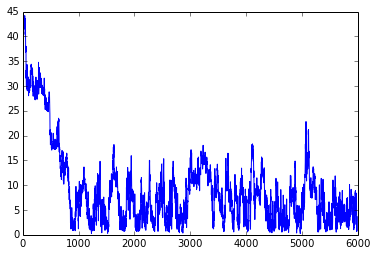

0.90664249491 [ 10.43659522] [ 5.08157824] [ 10.02582535]


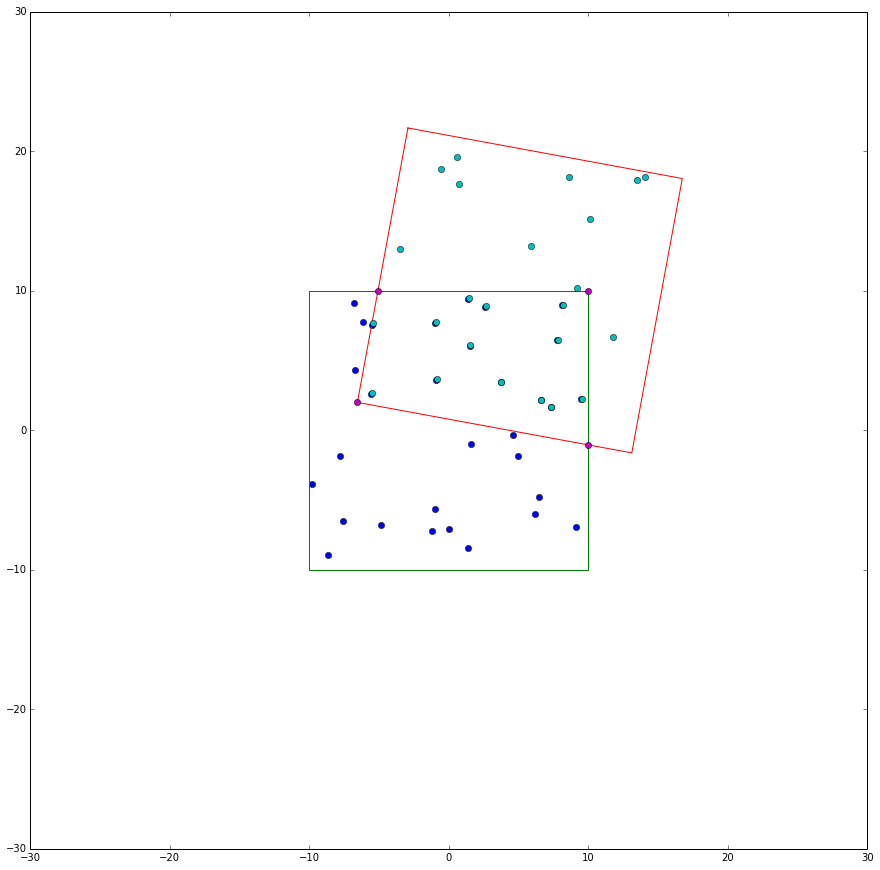

In [161]:
plt.plot(dist)
plt.show()
print prev_E,prev_roll,prev_deltax,prev_deltay

cxo_prev=rotate_cxo(prev_deltax,prev_deltay,prev_roll)
trans_sce=rotate_sources(obs1,prev_deltax,prev_deltay,prev_roll)
polybounds=calc_intersect_coords(cxo_fov,cxo_prev)

fig=plt.figure(figsize=(15,15))
plt.plot(obs0[:,0], obs0[:,1],'o')
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.plot(cxo_fov[0,:], cxo_fov[1,:])
plt.plot(cxo_prev[0,:],cxo_prev[1,:])
plt.plot(trans_sce[:,0], trans_sce[:,1],'o')
plt.plot(polybounds[0,:], polybounds[1,:],'o')
plt.show()

This can of course now be repeated for all of the observations that we have taken with Chandra, but I'll leave that for you to do on your own. Don't forget to play around with the painting values!